# Hospital Charges Prediction using Length of Stay Segmentation

### Segment-Specific LightGBM Modeling with SHAP Explainability

This notebook builds and evaluates multiple LightGBM models to predict hospital total charges based on patient demographics, clinical characteristics, and hospital details.  
By segmenting patients by **Length of Stay (LOS)** and engineering **SHAP-informed interaction features**, we improve prediction accuracy—especially for high-cost outliers and complex cases.
****

In [1]:
import numpy as np
import pandas as pd

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [2]:
df = pd.read_csv('../data/processed/model_input.csv')

# Remove invalid charge entries
df = df[df['total_charges'] > 0].copy()

# Log-transform the target variable to reduce skew
df['log_total_charges'] = np.log1p(df['total_charges'])

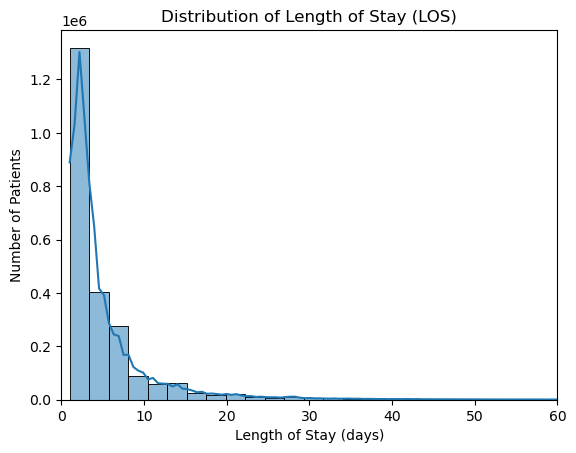

In [3]:
# Visualize the distribution of patient Length of Stay (LOS)
sns.histplot(df['los'], bins=50, kde=True)
plt.title("Distribution of Length of Stay (LOS)")
plt.xlabel("Length of Stay (days)")
plt.ylabel("Number of Patients")
plt.xlim(0, 60)
plt.show()

## Length of Stay (LOS) Distribution

- **Most patients** are discharged within **1 to 7 days**, indicating short stays are most common.
- There is a **steep drop-off** in frequency after day 7, with a **long right tail** extending past 30 days.
- The extreme skew in LOS motivates **segmenting the data into groups**: short, moderate, long, and extended.

## LOS Group Segmentation

Patients are grouped by length of stay to help reduce noise from skew and model heterogeneity more accurately:

- **Short**: 0–3 days  
- **Moderate**: 4–7 days  
- **Long**: 8–14 days  
- **Extended**: 15+ days  

In [4]:
# Segment Length of Stay into interpretable groups
df['los_group'] = pd.cut(
    df['los'],
    bins=[0, 3, 7, 14, df['los'].max()],
    labels=['short', 'moderate', 'long', 'extended'],
    right=True
)

# View proportion of patients in each LOS group
df['los_group'].value_counts(normalize=True)

los_group
short       0.563316
moderate    0.261496
long        0.111452
extended    0.063736
Name: proportion, dtype: float64

## Baseline Model Setup

We'll model each LOS group separately using the same input features. The target variable is log-transformed to stabilize variance and reduce the influence of extreme outliers.

In [5]:
# Define input features for modeling
feature_cols = [
    'gender_encoded',
    'age_group_encoded',
    'severity_encoded',
    'admission_encoded',
    'payment_type_encoded',
    'diagnosis_encoded',
    'procedure_encoded',
    'county_encoded',
    'los'  
]

In [6]:
# Prepare features and log-transformed target
X = df[feature_cols]
y = np.log1p(df['total_charges']) 


# Split dataset into separate DataFrames by LOS group
short_df = df[df['los_group'] == 'short']
moderate_df = df[df['los_group'] == 'moderate']
long_df = df[df['los_group'] == 'long']
extended_df = df[df['los_group'] == 'extended']

In [7]:
# Select features and target for short LOS group
X_short = short_df[feature_cols]  # Only include relevant model input features
y_short = np.log1p(short_df['total_charges'])  # Apply log-transform to stabilize variance

# Split into training and test sets 
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
X_short, y_short, test_size=0.2, random_state=42)

## Short LOS Patients


In [8]:
# Train and evaluate model for Short LOS group
model_s = lgb.LGBMRegressor(random_state=42)
model_s.fit(X_train_s, y_train_s)

# Predict in log space, then convert back to original scale
y_pred_log_s = model_s.predict(X_test_s)
y_pred_s = np.expm1(y_pred_log_s)
y_actual_s = np.expm1(y_test_s)

# Calculate MAE
mae_s = mean_absolute_error(y_actual_s, y_pred_s)
print(f"Short LOS MAE: ${mae_s:,.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 1055228, number of used features: 9
[LightGBM] [Info] Start training from score 9.650624
Short LOS MAE: $7,273.61


## Moderate LOS Patients

In [9]:
# Train and evaluate model for Moderate LOS group
X_moderate = moderate_df[feature_cols]
y_moderate = np.log1p(moderate_df['total_charges'])

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_moderate, y_moderate, test_size=0.2, random_state=42
)

model_m = lgb.LGBMRegressor(random_state=42)
model_m.fit(X_train_m, y_train_m)

y_pred_log_m = model_m.predict(X_test_m)
y_pred_m = np.expm1(y_pred_log_m)
y_actual_m = np.expm1(y_test_m)

mae_m = mean_absolute_error(y_actual_m, y_pred_m)
print(f"Moderate LOS MAE: ${mae_m:,.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 482
[LightGBM] [Info] Number of data points in the train set: 489844, number of used features: 9
[LightGBM] [Info] Start training from score 10.425097
Moderate LOS MAE: $13,135.13


## Long LOS Patients

In [10]:
# Train and evaluate model for Long LOS group
X_long = long_df[feature_cols]
y_long = np.log1p(long_df['total_charges'])

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
    X_long, y_long, test_size=0.2, random_state=42
)

model_l = lgb.LGBMRegressor(random_state=42)
model_l.fit(X_train_l, y_train_l)

y_pred_log_l = model_l.predict(X_test_l)
y_pred_l = np.expm1(y_pred_log_l)
y_actual_l = np.expm1(y_test_l)

mae_l = mean_absolute_error(y_actual_l, y_pred_l)
print(f"Long LOS MAE: ${mae_l:,.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 208776, number of used features: 9
[LightGBM] [Info] Start training from score 11.036781
Long LOS MAE: $23,670.70


## Extended LOS Patients

In [11]:
# Train and evaluate model for Extended LOS group
X_extended = extended_df[feature_cols]
y_extended = np.log1p(extended_df['total_charges'])

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X_extended, y_extended, test_size=0.2, random_state=42
)

model_e = lgb.LGBMRegressor(random_state=42)
model_e.fit(X_train_e, y_train_e)

y_pred_log_e = model_e.predict(X_test_e)
y_pred_e = np.expm1(y_pred_log_e)
y_actual_e = np.expm1(y_test_e)

mae_e = mean_absolute_error(y_actual_e, y_pred_e)
print(f"Extended LOS MAE: ${mae_e:,.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 119393, number of used features: 9
[LightGBM] [Info] Start training from score 11.777569
Extended LOS MAE: $60,723.69


## Summary of Model Performance by LOS

| LOS Group     | MAE ($)         | Interpretation                                     |
|---------------|------------------|----------------------------------------------------|
| **Short**     | ~7,274           | Very predictable — low variance, strong performance. |
| **Moderate**  | ~13,135          | Moderate complexity — higher spread of cases.      |
| **Long**      | ~23,671          | Complex and rare procedures increase error.        |
| **Extended**  | ~60,724          | Highest costs and variance — model struggles.      |



## SHAP Analysis for Model Explainability

We use SHAP (SHapley Additive exPlanations) to interpret model predictions by quantifying each feature’s contribution to the predicted hospital charges.

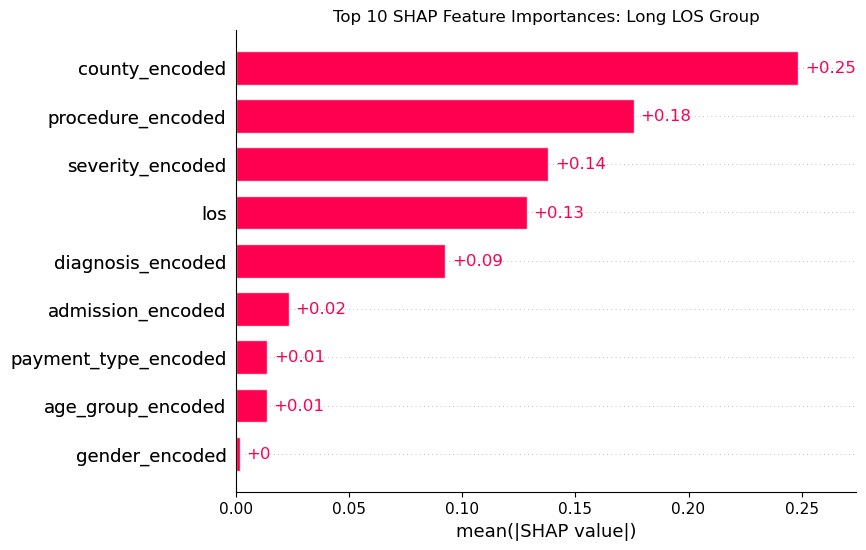

In [17]:
# Prepare input features for SHAP explanation
long_cases = long_df[feature_cols]
extended_cases = extended_df[feature_cols]

# SHAP Explainer for Long LOS Group
explainer_long = shap.Explainer(model_l)
shap_values_long = explainer_long(long_cases)

# SHAP Explainer for Extended LOS Group
explainer_ext = shap.Explainer(model_e)
shap_values_ext = explainer_ext(extended_cases)

# Visualize top 10 most impactful features for the Long LOS model
ax = shap.plots.bar(shap_values_long, max_display=10, show=False)
ax.set_title("Top 10 SHAP Feature Importances: Long LOS Group")
plt.show()


### SHAP Insights: Long LOS Group

- **County** and **procedure type** were the top drivers of hospital charges.
- Clinical **severity** and **diagnosis** had meaningful but secondary influence.
- The model identifies **geographic and procedural variation** as cost determinants in long stays.

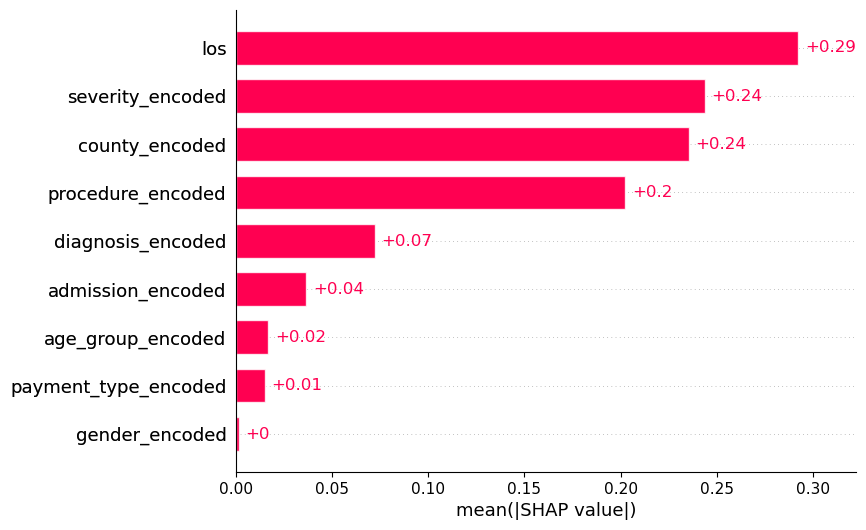

In [ ]:
# Visualize top 10 most impactful features for the Extended LOS model
shap.plots.bar(shap_values_ext, max_display=10)
plt.title("Top 10 SHAP Feature Importances – Extended LOS Group")
plt.show()

### The most important features for patients with **extremely long** hospitalizations were:
- **los:** The length of stay was the strongest predictor, directly driving total charges.
- **severity_encoded:** Very high-severity cases were tightly linked to prolonged costs.
- **county_encoded:** Geographic location continued to shape cost variation.


## Feature Engineering: SHAP-Informed Interaction Terms

To improve accuracy for complex LOS cases, we introduce interaction features based on SHAP insights:

- `los_x_severity`: Captures impact of prolonged stays in severe cases.  
- `los_x_procedure`: Accounts for cost inflation in high-LOS procedural cases.  
- `severity_x_procedure`: Combines clinical complexity and treatment type.  
- `los_x_county`: Captures regional variation in extended stays.

In [ ]:
# Engineer interaction features based on SHAP insights
df['los_x_severity'] = df['los'] * df['severity_encoded']
df['los_x_procedure'] = df['los'] * df['procedure_encoded']
df['severity_x_procedure'] = df['severity_encoded'] * df['procedure_encoded']
df['los_x_county'] = df['los'] * df['county_encoded']

# Add interactions to feature list
interaction_features = ['los_x_severity', 'los_x_procedure', 'severity_x_procedure', 'los_x_county']
feature_cols = feature_cols + interaction_features

# Remove any duplicates (LightGBM doesn't allow repeated column names)
feature_cols = list(dict.fromkeys(feature_cols))

In [ ]:
# Train model for SHORT LOS group
X_short = short_df[feature_cols]
y_short = np.log1p(short_df['total_charges'])

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_short, y_short, test_size=0.2, random_state=42
)
model_s = lgb.LGBMRegressor(random_state=42)
model_s.fit(X_train_s, y_train_s)

# Train model for MODERATE LOS group
X_moderate = moderate_df[feature_cols]
y_moderate = np.log1p(moderate_df['total_charges'])

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_moderate, y_moderate, test_size=0.2, random_state=42
)
model_m = lgb.LGBMRegressor(random_state=42)
model_m.fit(X_train_m, y_train_m)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 1055228, number of used features: 13
[LightGBM] [Info] Start training from score 9.650624
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 489844, number of used features: 13
[LightGBM] [Info] Start training from score 10.425097


LGBMRegressor(random_state=42)

In [ ]:
# Split by LOS group (with updated features)
short_df = df[df['los_group'] == 'short'].copy()
moderate_df = df[df['los_group'] == 'moderate'].copy()
long_df = df[df['los_group'] == 'long'].copy()
extended_df = df[df['los_group'] == 'extended'].copy()

# Prepare data for LONG LOS model
X_long = long_df[feature_cols]
y_long = np.log1p(long_df['total_charges'])

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
    X_long, y_long, test_size=0.2, random_state=42
)

# Prepare data for EXTENDED LOS model
X_extended = extended_df[feature_cols]
y_extended = np.log1p(extended_df['total_charges'])

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X_extended, y_extended, test_size=0.2, random_state=42
)

## Long

In [ ]:
# Train and evaluate model for LONG LOS group
model_l = lgb.LGBMRegressor(random_state=42)
model_l.fit(X_train_l, y_train_l)

# Predict and inverse transform
y_pred_log_l = model_l.predict(X_test_l)
y_pred_l = np.expm1(y_pred_log_l)
y_actual_l = np.expm1(y_test_l)

# Evaluate model performance
mae_l = mean_absolute_error(y_actual_l, y_pred_l)
print("Long LOS MAE:", mae_l)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1197
[LightGBM] [Info] Number of data points in the train set: 208776, number of used features: 13
[LightGBM] [Info] Start training from score 11.036781


LGBMRegressor(random_state=42)

In [ ]:
# Train and evaluate model for EXTENDED LOS group
model_e = lgb.LGBMRegressor(random_state=42)
model_e.fit(X_train_e, y_train_e)

# Predict and inverse transform
y_pred_log_e = model_e.predict(X_test_e)
y_pred_e = np.expm1(y_pred_log_e)
y_actual_e = np.expm1(y_test_e)

# Evaluate model performance
mae_e = mean_absolute_error(y_actual_e, y_pred_e)
print("Extended LOS MAE:", mae_e)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1561
[LightGBM] [Info] Number of data points in the train set: 119393, number of used features: 13
[LightGBM] [Info] Start training from score 11.777569


LGBMRegressor(random_state=42)

## Final Evaluation with Interaction Features

The models are retrained with engineered interaction terms to capture complex cost drivers. This adjustment improves accuracy, particularly for long and extended LOS cases.

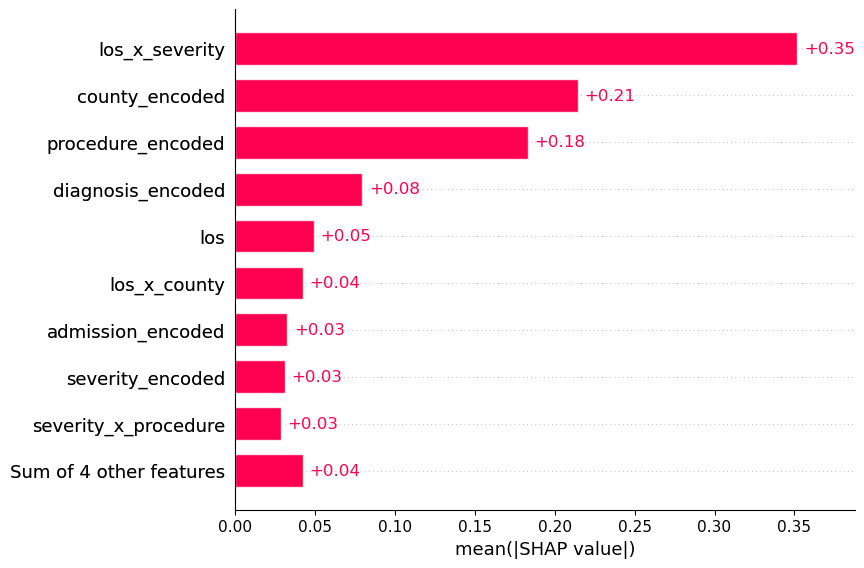

In [ ]:
# SHAP explainability for EXTENDED LOS group
explainer_e = shap.Explainer(model_e)

# Apply explainer to test set
shap_values_e = explainer_e(X_test_e)

# Visualize top 10 most important features
shap.plots.bar(shap_values_e, max_display=10)

### SHAP Summary: Extended LOS with Interactions

- **`los_x_severity`** emerges as the dominant predictor, validating our feature engineering approach.
- Cost prediction improves when **interactions** between key features are explicitly modeled.
- High-cost cases often arise from **multiple overlapping factors**, not just one variable.

In [ ]:
# Save trained models
import joblib

# joblib.dump(model_s, "../models/model_short.pkl")
# joblib.dump(model_m, "../models/model_moderate.pkl")
# joblib.dump(model_l, "../models/model_long.pkl")
# joblib.dump(model_e, "../models/model_extended.pkl")

['../models/model_moderate.pkl']